# Ink Detection Segment Anything Approach


In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-5vjic5xo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-5vjic5xo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... - done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36621 sha256=233192e6bd2a360a56799082224cc00e226211895f27eaabcd769b0af767460f
  Stored in directory: /tmp/pip-ephem-wheel-cache-x7w_nppx/wheels/6e/b2/38/082465c177a067501384fd15cb18be1128372ef60f27a1c426
Successfully built segment-anything


In [2]:
import os
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor

In [3]:
tpaths=[]
for dirname, _, filenames in os.walk('/kaggle/input/vesuvius-challenge-ink-detection/train/1'):
    for filename in filenames:
        if filename[-4:]=='.tif':
            tpaths+=[(os.path.join(dirname, filename))]
tpaths=sorted(tpaths)
print(tpaths[0])
print(len(tpaths))

/kaggle/input/vesuvius-challenge-ink-detection/train/1/surface_volume/00.tif
65


## mask_generator

In [4]:
sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth"
model_type = "vit_h" #
device = "cpu"  #cpu,cuda
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [5]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.5)))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

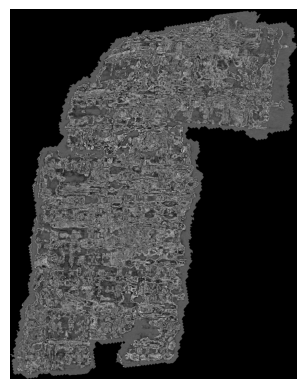

In [6]:
path=tpaths[4]
image=cv2.imread(path)
image=cv2.resize(image,dsize=(0,0),fx=0.1,fy=0.1)  
plt.imshow(image)
plt.axis('off') 
plt.show()

1636 545
1266 422
0 0 (545, 422, 3)
0 1 (545, 422, 3)
0 2 (545, 422, 3)
1 0 (545, 422, 3)
1 1 (545, 422, 3)
1 2 (545, 422, 3)
2 0 (545, 422, 3)
2 1 (545, 422, 3)
2 2 (545, 422, 3)


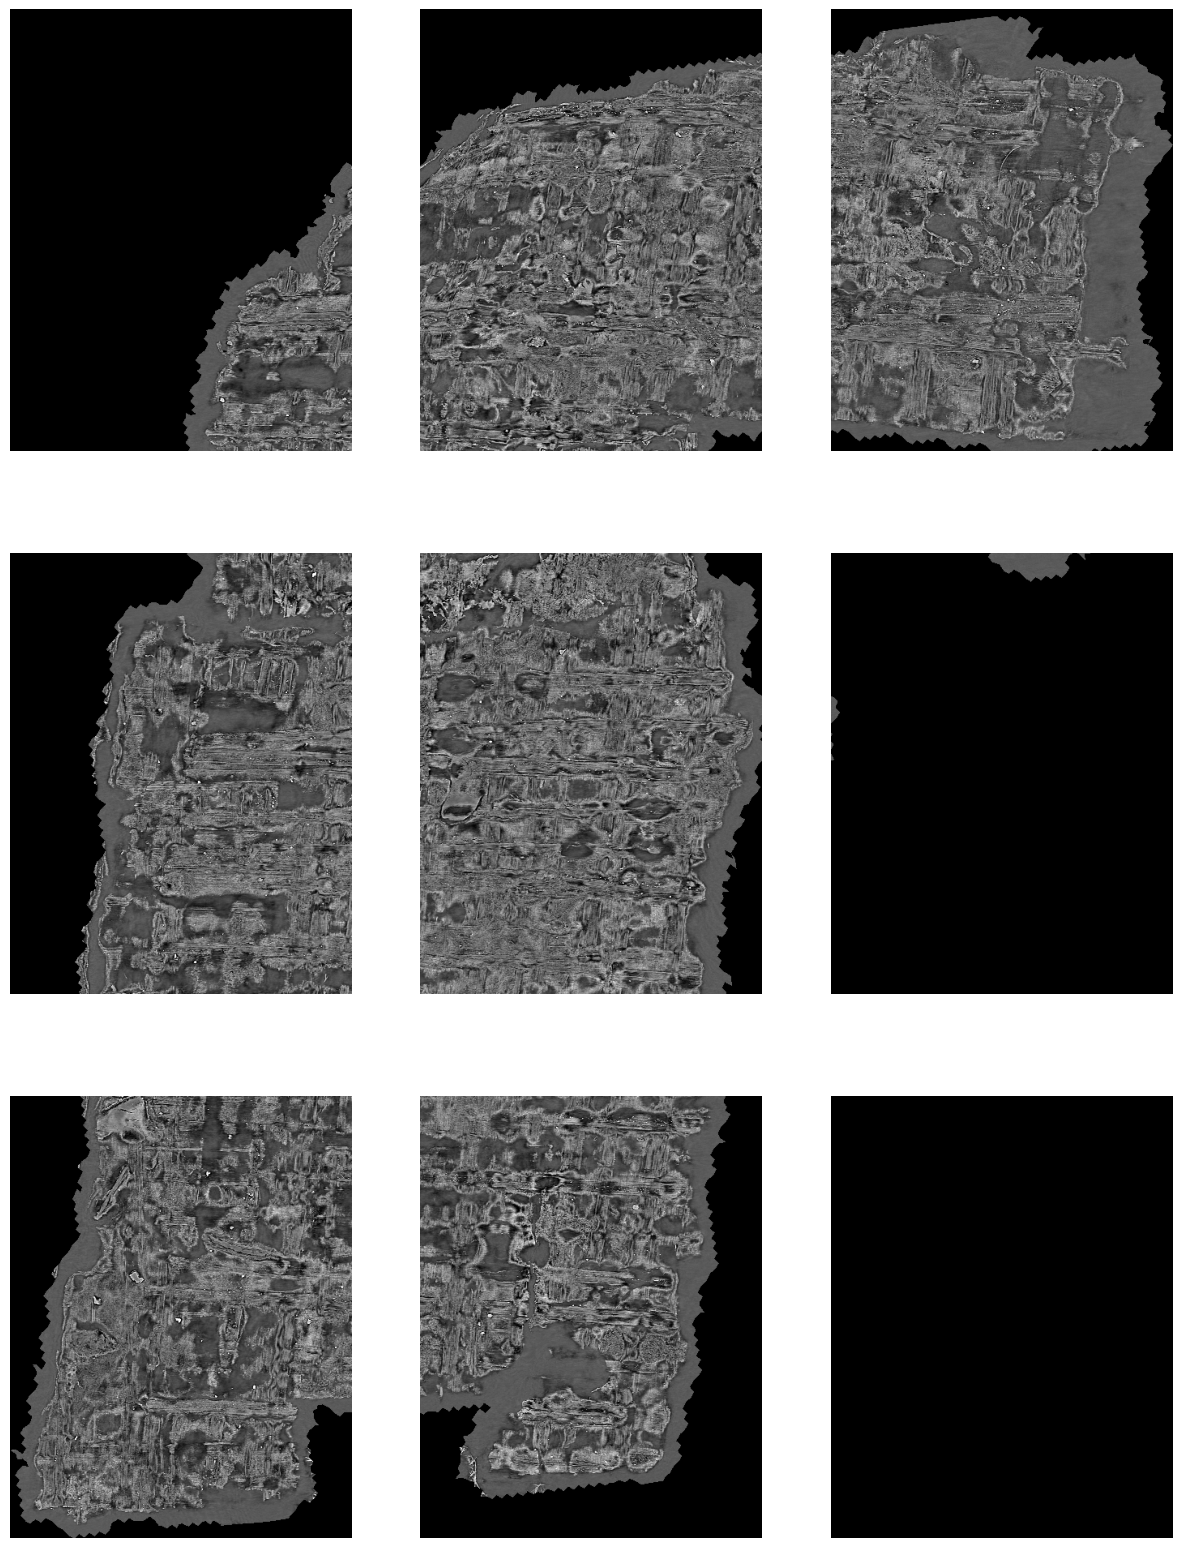

In [7]:
image=cv2.imread(path)
image=cv2.resize(image,dsize=(0,0),fx=0.2,fy=0.2)  
(h,w,c)=image.shape
print(h,h//3)
print(w,w//3)
fig, axs = plt.subplots(3,3,figsize=(15,20))
for i in range(9):
    r=i//3
    c=i%3
    imagei=image[(h//3)*r:(h//3)*(r+1),(w//3)*c:(w//3)*(c+1),:]
    print(r,c,imagei.shape)
    axs[r][c].imshow(imagei)
    axs[r][c].axis('off') 
plt.show()

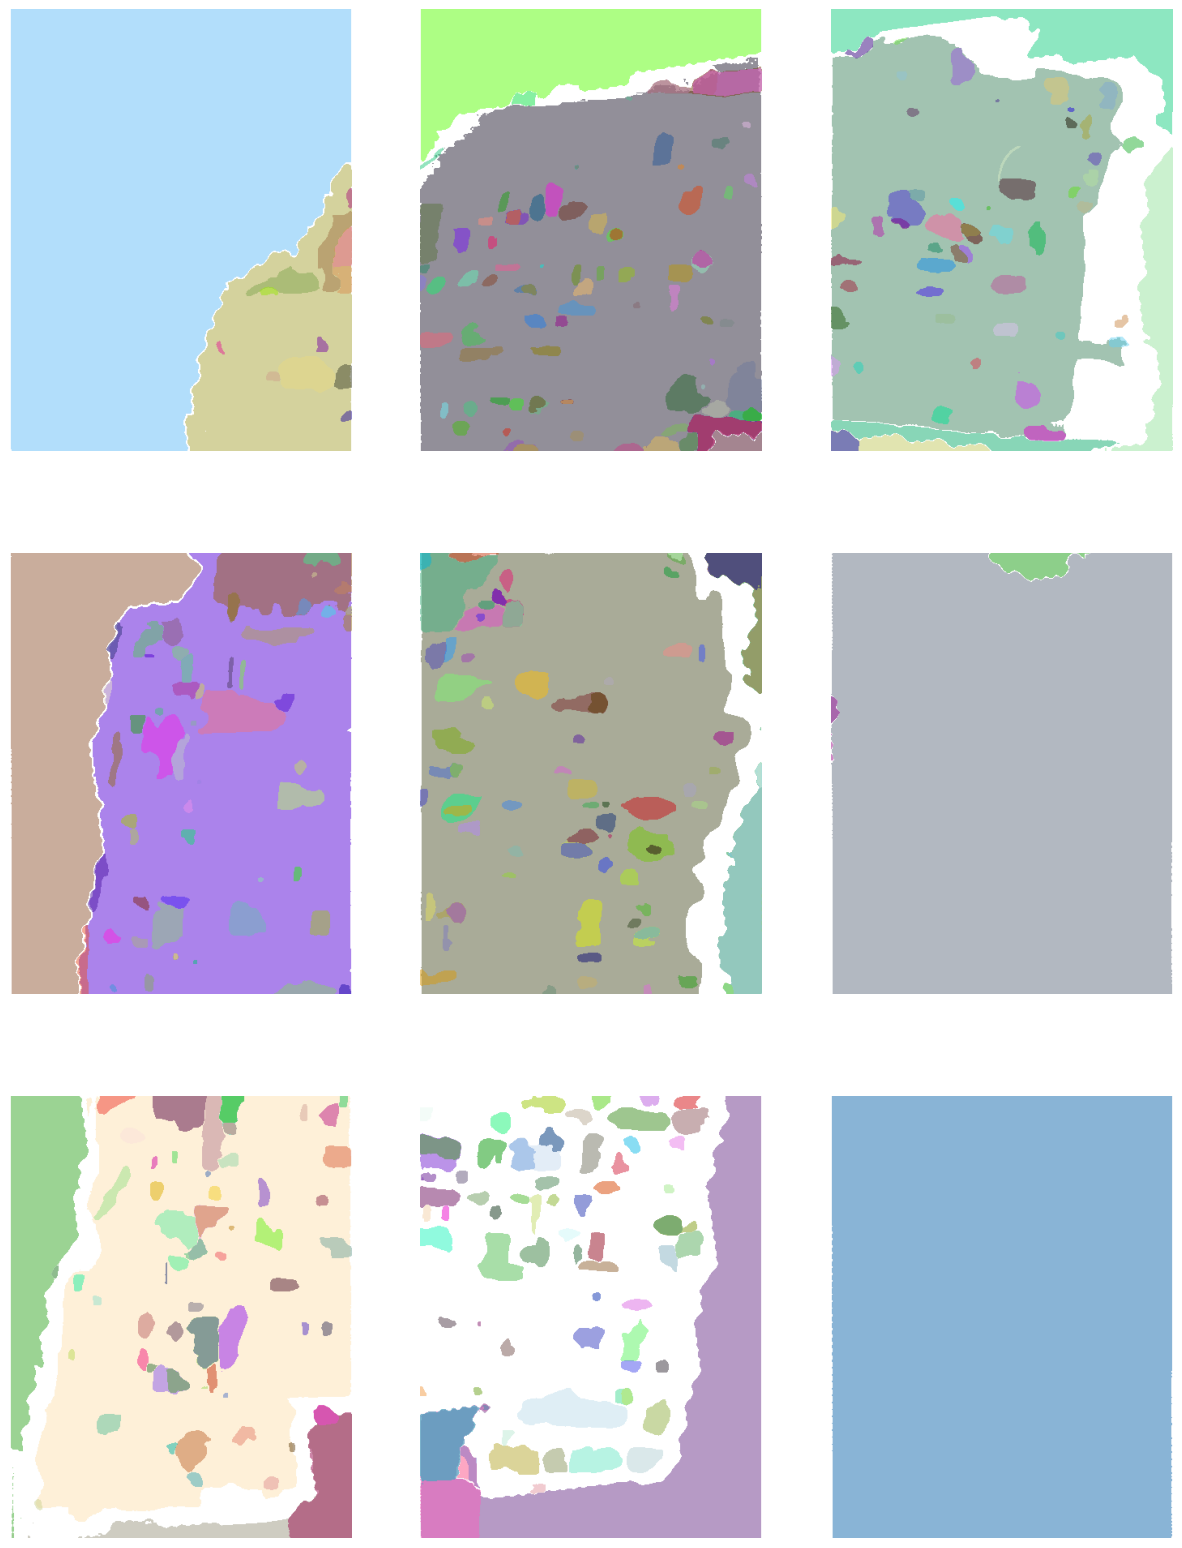

In [8]:
image=cv2.imread(path)
image=cv2.resize(image,dsize=(0,0),fx=0.2,fy=0.2)  
(h,w,c)=image.shape
fig, axs = plt.subplots(3,3,figsize=(15,20))
for i in range(9):
    r=i//3
    c=i%3
    imagei=image[(h//3)*r:(h//3)*(r+1),(w//3)*c:(w//3)*(c+1),:]
    masks = mask_generator.generate(imagei)
    show_anns(masks,axs[r][c])
    axs[r][c].axis('off') 
plt.show()